In [6]:
from aqchem.chemistry import Solute, elements
from aqchem.equilibria import Equilibrium, EqSystem, charge_balance, atom_balance
from IPython.display import Latex, display
import periodictable

In [7]:
def show(s): display(Latex('$'+s+'$'))

In [8]:
substances = Hp, OHm, NH4p, NH3, Cupp, CuNH31pp, CuNH32pp, CuNH33pp, CuNH34pp, CuNH35pp, H2O, Cu2OH2pp, CuOH2, CuOH3m, CuOH4mm = [#, CuOHp, CuOH2, =
    Solute(n, latex_name=l, formula=periodictable.formula(n)) for n, l in [
        ('H{+}', 'H^+'), ('HO{-}', 'OH^-'), ('NH3 + H{+}', 'NH_4^+'),
        ('NH3', 'NH_3'), ('Cu{2+}', 'Cu^{2+}'), ('Cu{2+}NH3', 'Cu(NH_3)^{2+}'),
        ('Cu{2+}(NH3)2', 'Cu(NH_3)_2^{2+}'), ('Cu{2+}(NH3)3', 'Cu(NH_3)_3^{2+}'),
        ('Cu{2+}(NH3)4', 'Cu(NH_3)_4^{2+}'), ('Cu{2+}(NH3)5', 'Cu(NH_3)_5^{2+}'), 
        ('H2O', 'H_2O'), ('2Cu{2+} + 2HO{-}', 'Cu_2(OH)_2^{2+}'),
        ('Cu{2+} + 2HO{-}', 'Cu(OH_2)(s)'),
        ('Cu{2+} + 3HO{-}', 'Cu(OH)_3^-'), ('Cu{2+} + 4HO{-}', 'Cu(OH)_4^{2-}'),
    ]]
CuOH2.solid = True

In [9]:
show(', '.join([s.latex_name for s in substances])) # + r'(\mathrm{%s})' % (str(s.formula.atoms) + ', ' + str(s.charge))

<IPython.core.display.Latex object>

In [10]:
init_conc = {Hp: 1e-7, OHm: 1e-7, NH4p: 0, NH3: 1.0, Cupp: 1e-2, 
            CuNH31pp: 0, CuNH32pp: 0, CuNH33pp: 0, CuNH34pp: 0, CuNH35pp: 0,
            H2O: 55.5, Cu2OH2pp: 0, CuOH2: 0, CuOH3m: 0, CuOH4mm: 0}

In [11]:
H2O_c = init_conc[H2O]
w_autop = Equilibrium({H2O: 1}, {Hp: 1, OHm: 1}, 10**-14/H2O_c)
NH4p_pr = Equilibrium({NH4p: 1}, {Hp: 1, NH3: 1}, 10**-9.26)
CuOH2_s = Equilibrium({CuOH2: 1}, {Cupp: 1, OHm: 2}, 10**-18.8)
CuOH_B3 = Equilibrium({CuOH2: 1, OHm: 1}, {CuOH3m: 1}, 10**-3.6)
CuOH_B4 = Equilibrium({CuOH2: 1, OHm: 2}, {CuOH4mm: 1}, 10**-2.7)
Cu2OH2 = Equilibrium({Cupp: 2, H2O: 2}, {Cu2OH2pp: 1, Hp: 2}, 10**4.3 * H2O_c**2)
CuNH3_B1 = Equilibrium({CuNH31pp: 1}, {Cupp: 1, NH3: 1}, 10**4.3)
CuNH3_B2 = Equilibrium({CuNH32pp: 1}, {Cupp: 1, NH3: 2}, 10**7.9)
CuNH3_B3 = Equilibrium({CuNH33pp: 1}, {Cupp: 1, NH3: 3}, 10**10.8)
CuNH3_B4 = Equilibrium({CuNH34pp: 1}, {Cupp: 1, NH3: 4}, 10**13.0)
CuNH3_B5 = Equilibrium({CuNH35pp: 1}, {Cupp: 1, NH3: 5}, 10**12.4)
equilibria = w_autop, NH4p_pr, CuNH3_B1, CuNH3_B2, CuNH3_B3, CuNH3_B4, CuNH3_B5, Cu2OH2, CuOH2_s, CuOH_B3, CuOH_B4

In [12]:
for eq in equilibria:
    show(eq.latex())

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [13]:
reaction_system = EqSystem(equilibria, substances)

In [14]:
import sympy as sp
#sp.init_printing()
y = sp.symbols('y:'+str(len(substances)))
s = sp.symbols('s')

ys = []
class LatexSymbol(sp.Symbol):
    def _print_latex(self):
        return self.name
  
for sbs in reaction_system.substances:
    ys.append(LatexSymbol('[' + sbs.latex_name + ']'))
    print(ys[-1].name)
ys

In [15]:
qk = reaction_system.qk(y, scaling=s)
qk

[-1.8018018018018e-16*s + y0*y1/y10,
 -5.49540873857625e-10*s + y0*y3/y2,
 -19952.6231496888*s + y3*y4/y5,
 -79432823.4724282*s**2 + y3**2*y4/y6,
 -63095734448.0194*s**3 + y3**3*y4/y7,
 -10000000000000.0*s**4 + y3**4*y4/y8,
 -2511886431509.58*s**5 + y3**5*y4/y9,
 y0**2*y11/(y10**2*y4**2) - 61459067.4568289/s,
 -1.58489319246111e-19*s**3/y12 + y1**2*y4/y12,
 -0.000251188643150958/y12 + y13/(y1*y12),
 y14/(y1**2*y12) - 0.00199526231496888/(s*y12)]

In [16]:
charge_balance(substances, y)

y0 - y1 + 2*y11 - y13 - 2*y14 + y2 + 2*y4 + 2*y5 + 2*y6 + 2*y7 + 2*y8 + 2*y9

In [17]:
atom_balance(substances, y, 1)

y0 + y1 + 2*y10 + 2*y11 + 2*y12 + 3*y13 + 4*y14 + 4*y2 + 3*y3 + 3*y5 + 6*y6 + 9*y7 + 12*y8 + 15*y9

In [18]:
reaction_system.equilibrium_quotients(y)

[y0*y1/y10,
 y0*y3/y2,
 y3*y4/y5,
 y3**2*y4/y6,
 y3**3*y4/y7,
 y3**4*y4/y8,
 y3**5*y4/y9,
 y0**2*y11/(y10**2*y4**2),
 y1**2*y4/y12,
 y13/(y1*y12),
 y14/(y1**2*y12)]

In [19]:
chg_vec = reaction_system.charge_balance_vector()
atm_vecs, atm_nrs = reaction_system.atom_balance_vectors()
import numpy as np
arr = np.array(atm_vecs)
arr.shape, atm_nrs, arr, chg_vec

((4, 15),
 [1, 7, 8, 29],
 array([[ 1,  1,  4,  3,  0,  3,  6,  9, 12, 15,  2,  2,  2,  3,  4],
        [ 0,  0,  1,  1,  0,  1,  2,  3,  4,  5,  0,  0,  0,  0,  0],
        [ 0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  2,  2,  3,  4],
        [ 0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  0,  2,  1,  1,  1]]),
 [1, -1, 1, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, -1, -2])

In [20]:
import sympy
M = sympy.Matrix([chg_vec] + atm_vecs)
rref, pivot = M.rref()
M, rref, pivot

(Matrix([
 [1, -1, 1, 0, 2, 2, 2, 2,  2,  2, 0, 2, 0, -1, -2],
 [1,  1, 4, 3, 0, 3, 6, 9, 12, 15, 2, 2, 2,  3,  4],
 [0,  0, 1, 1, 0, 1, 2, 3,  4,  5, 0, 0, 0,  0,  0],
 [0,  1, 0, 0, 0, 0, 0, 0,  0,  0, 1, 2, 2,  3,  4],
 [0,  0, 0, 0, 1, 1, 1, 1,  1,  1, 0, 2, 1,  1,  1]]), Matrix([
 [1, 0, 0, -1, 0, -1, -2, -3, -4, -5, 1, 0, 0, 0, 0],
 [0, 1, 0,  0, 0,  0,  0,  0,  0,  0, 1, 2, 2, 3, 4],
 [0, 0, 1,  1, 0,  1,  2,  3,  4,  5, 0, 0, 0, 0, 0],
 [0, 0, 0,  0, 1,  1,  1,  1,  1,  1, 0, 2, 1, 1, 1],
 [0, 0, 0,  0, 0,  0,  0,  0,  0,  0, 0, 0, 0, 0, 0]]), [0, 1, 2, 4])

In [21]:
rref, pivot = reaction_system.rref()
rref, pivot, reaction_system.independent_atoms_from_pivot(pivot)

([[1, 0, 0, -1, 0, -1, -2, -3, -4, -5, 1, 0, 0, 0, 0],
  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 3, 4],
  [0, 0, 1, 1, 0, 1, 2, 3, 4, 5, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1]],
 [0, 1, 2, 4],
 [0, 1, 7, 29])

In [22]:
qk

[-1.8018018018018e-16*s + y0*y1/y10,
 -5.49540873857625e-10*s + y0*y3/y2,
 -19952.6231496888*s + y3*y4/y5,
 -79432823.4724282*s**2 + y3**2*y4/y6,
 -63095734448.0194*s**3 + y3**3*y4/y7,
 -10000000000000.0*s**4 + y3**4*y4/y8,
 -2511886431509.58*s**5 + y3**5*y4/y9,
 y0**2*y11/(y10**2*y4**2) - 61459067.4568289/s,
 -1.58489319246111e-19*s**3/y12 + y1**2*y4/y12,
 -0.000251188643150958/y12 + y13/(y1*y12),
 y14/(y1**2*y12) - 0.00199526231496888/(s*y12)]

In [23]:
c0arr = np.array([init_conc[k] for k in reaction_system.substances])
scaling = 1.0
logC = False
f, j = reaction_system.num_cb_factory(c0arr*scaling, True, scaling=scaling, logC=logC)
c0arr

(15, 15)
Matrix([[y_1/y_10, y_0/y_10, 0, 0, 0, 0, 0, 0, 0, 0, -y_0*y_1/y_10**2, 0, 0, 0, 0], [y_3/y_2, 0, -y_0*y_3/y_2**2, y_0/y_2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, y_4/y_5, y_3/y_5, -y_3*y_4/y_5**2, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 2*y_3*y_4/y_6, y_3**2/y_6, 0, -y_3**2*y_4/y_6**2, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 3*y_3**2*y_4/y_7, y_3**3/y_7, 0, 0, -y_3**3*y_4/y_7**2, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 4*y_3**3*y_4/y_8, y_3**4/y_8, 0, 0, 0, -y_3**4*y_4/y_8**2, 0, 0, 0, 0, 0, 0], [0, 0, 0, 5*y_3**4*y_4/y_9, y_3**5/y_9, 0, 0, 0, 0, -y_3**5*y_4/y_9**2, 0, 0, 0, 0, 0], [2*y_0*y_11/(y_10**2*y_4**2), 0, 0, 0, -2*y_0**2*y_11/(y_10**2*y_4**3), 0, 0, 0, 0, 0, -2*y_0**2*y_11/(y_10**3*y_4**2), y_0**2/(y_10**2*y_4**2), 0, 0, 0], [0, 2*y_1*y_4/y_12, 0, 0, y_1**2/y_12, 0, 0, 0, 0, 0, 0, 0, -y_1**2*y_4/y_12**2 + 1.58489319246111e-19/y_12**2, 0, 0], [0, -y_13/(y_1**2*y_12), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.000251188643150958/y_12**2 - y_13/(y_1*y_12**2), 1/(y_1*y_12), 0], [0, -2*y_14/(y

array([  1.00000000e-07,   1.00000000e-07,   0.00000000e+00,
         1.00000000e+00,   1.00000000e-02,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   5.55000000e+01,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00])

In [24]:
x0 = c0arr+1e-17
f(np.log(x0) if logC else x0)

[  1.00000000e-07   1.00000000e-07   1.00000000e-17   1.00000000e+00
   1.00000000e-02   1.00000000e-17   1.00000000e-17   1.00000000e-17
   1.00000000e-17   1.00000000e-17   5.55000000e+01   1.00000000e-17
   1.00000000e-17   1.00000000e-17   1.00000000e-17]


[3.603622618233721e-26,
 10000000001.0,
 999999999980048.38,
 999999920567177.5,
 999936904265553.0,
 990000000000001.0,
 997488113568491.38,
 -61459067.4568289,
 9.9841510700754004,
 -25118854315095.801,
 -99526231516887.984,
 0.0,
 0.0,
 0.0,
 1.1449174941446927e-16]

[[1.801801801981982e-09, 1.801801801981982e-09, 0.0, 0.0],
 [1e+17, 0.0, -1.0000000000999999e+27, 10000000001.0],
 [0.0, 0.0, 0.0, 1000000000000001.0],
 [0.0, 0.0, 0.0, 2000000000000002.0],
 [0.0, 0.0, 0.0, 3000000000000003.0],
 [0.0, 0.0, 0.0, 4000000000000004.0],
 [0.0, 0.0, 0.0, 5000000000000005.0]]

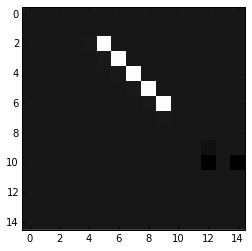

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
jmat = j(np.log(x0) if logC else x0)
plt.imshow(jmat, cmap='binary', interpolation='None')
jmat[:7, :4].tolist()

In [26]:
len(substances)

15

In [27]:
from scipy.optimize import root
x0 = [1]*len(substances)
root(f, x0, jac=j)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[   1.0035143     1.            1.          183.01446491  229.78832562
    0.999999      0.99841028    0.36862021  -57.86291311   -8.66756999
    0.99648571    1.00136667    1.            1.            1.        ]
[   3.19713815   -0.63545859   -1.7620717   -88.22693939 -100.68604883
    0.27381967   -4.68647209   -9.48271796   -1.02658788   39.32783724
    1.56493355    6.19784745    1.96373934    0.32803867   -1.30910075]
[   3.19713815   -0.63545859   -1.7620717   -88.2269396  -100.68605011
    0.27381967   -4.68647202   -9.48272045   -1.02658783   39.32783702
    1.56493268    6.19784754    1.96373934    0.32803867   -1.30910075]


  status: 1
 success: True
     qtf: array([ -1.80115885e+03,   2.16393943e+01,  -8.10622018e+04,
         5.63927187e+12,  -8.62075028e+12,   2.00479626e+08,
         7.03406415e+08,   8.62981176e+10,   9.06405256e+05,
        -3.17536302e+05,  -1.08466885e+05,  -1.16791751e+05,
         5.79285219e+04,   4.87840290e+04,   6.14585183e+07])
    nfev: 4
       r: array([  5.00816365e+01,  -1.65645006e-02,   9.08269205e+01,
        -1.83396602e+00,   1.61553868e-09,  -1.99673986e-02,
        -3.99347972e-02,  -5.99021958e-02,  -7.98695944e-02,
        -9.98369931e-02,   1.32410958e-02,   1.31224758e-08,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -6.54109335e+01,  -2.30007813e-02,   4.64428949e-04,
        -2.04853332e-01,   5.05649389e-06,   1.01129878e-05,
         1.51694817e-05,   2.02259755e-05,   2.52824694e-05,
        -4.12015917e-02,  -3.05759281e-02,  -1.04662749e+01,
        -5.09319930e-02,   3.90207014e-02,  -2.19832695e+00,
        -1.24505219e+00, 

In [28]:
reaction_system.root(init_conc, scaling=scaling, logC=logC, delta=1e-15)

(15, 15)
Matrix([[y_1/y_10, y_0/y_10, 0, 0, 0, 0, 0, 0, 0, 0, -y_0*y_1/y_10**2, 0, 0, 0, 0], [y_3/y_2, 0, -y_0*y_3/y_2**2, y_0/y_2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, y_4/y_5, y_3/y_5, -y_3*y_4/y_5**2, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 2*y_3*y_4/y_6, y_3**2/y_6, 0, -y_3**2*y_4/y_6**2, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 3*y_3**2*y_4/y_7, y_3**3/y_7, 0, 0, -y_3**3*y_4/y_7**2, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 4*y_3**3*y_4/y_8, y_3**4/y_8, 0, 0, 0, -y_3**4*y_4/y_8**2, 0, 0, 0, 0, 0, 0], [0, 0, 0, 5*y_3**4*y_4/y_9, y_3**5/y_9, 0, 0, 0, 0, -y_3**5*y_4/y_9**2, 0, 0, 0, 0, 0], [2*y_0*y_11/(y_10**2*y_4**2), 0, 0, 0, -2*y_0**2*y_11/(y_10**2*y_4**3), 0, 0, 0, 0, 0, -2*y_0**2*y_11/(y_10**3*y_4**2), y_0**2/(y_10**2*y_4**2), 0, 0, 0], [0, 2*y_1*y_4/y_12, 0, 0, y_1**2/y_12, 0, 0, 0, 0, 0, 0, 0, -y_1**2*y_4/y_12**2 + 1.58489319246111e-19/y_12**2, 0, 0], [0, -y_13/(y_1**2*y_12), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.000251188643150958/y_12**2 - y_13/(y_1*y_12**2), 1/(y_1*y_12), 0], [0, -2*y_14/(y

aqchem/equilibria.py:40: RuntimeWarning: divide by zero encountered in true_divide
  limits = c0/stoich


ValueError: f(a) and f(b) must have different signs

In [ ]:
i = sp.symbols('i:'+str(len(y)))
reaction_system.f(y, i, scaling=s, reduced=True)

In [ ]:
f_elim, j_elim, elim = reaction_system.num_cb_factory(c0arr*scaling, True, scaling=scaling, logC=logC, reduced=True)
print(elim)

In [ ]:
c0arr_elim = np.array([x for idx, x in enumerate(c0arr) if idx not in elim]) + 1e-13
x0elim = np.log(c0arr_elim) if logC else c0arr_elim
f_elim(x0elim)

In [ ]:
jmat = j_elim(x0elim)
plt.imshow(jmat, cmap='binary', interpolation='None')
x0elim

In [ ]:
jmat

In [ ]:
reaction_system.root(init_conc, scaling=1e8, logC=False, delta=1e-8, reduced=True, square=True, tol=1e-5)